In [1]:
import matplotlib.pyplot as plt
from os import walk

import json
from matplotlib.ticker import MultipleLocator
from pennylane import numpy as np

plt.ioff() ## To display image only when required - plt.show()

FILES_NAMES = {"simplified_2_design":{"fd":[  "simplified2design_4layers_fd_1"],"ps":["simplified2design_4layers_ps_1"]},
               "single_double":{"fd":["meta_single_doubles_fd_1"],"ps":["meta_single_doubles_ps_1"]},
               "double":{"fd":["meta_doubles_fd_1"],"ps":["meta_doubles_ps_1"]},               
               "kupccgsd":{"fd":["kupccgsd_1layers_fd_1"],"ps":["kupccgsd_1layers_ps_1"]}}

DATA = {i:{"fd":[],"ps":[]} for i in FILES_NAMES}

with open('./h2_fci.json', 'r') as reader:
    # Read & print the entire file
    data = reader.read()
    fci_h2 = json.loads(data)   

DICT_GRAD_METHOD = {"fd":"Finite Diff", "ps":"Parameter Shift"}
DICT_ANSATZ = {"simplified_2_design":"Simplified Two Design 4 Layers", "single_double": "Single & Double Excitations", "double": "Double Excitations", "kupccgsd":"k-UpCCGSD 1 layer"}

optimizers = ["gradient_descent", "spsa", "adam", "demon_adam"]
train_types= ['vqe_random', 'vqe','meta', 'opt_meta']
all_ansatz = ["simplified_2_design", "single_double", "double", "kupccgsd"]


test_points=fci_h2["points"]
fci_energies = fci_h2["energies"]
    

In [2]:
for ansatz in FILES_NAMES:
    for diff_method in FILES_NAMES[ansatz]:
        for file in FILES_NAMES[ansatz][diff_method]:
            with open(f'./{file}.json', 'r') as reader:
                # Read & print the entire file
                data = reader.read()
                DATA[ansatz][diff_method].append(json.loads(data))


In [3]:
f = []
for (dirpath, dirnames, filenames) in walk('./'):
    f.extend(filenames)
    break

# Ordered by pairs - fd,ps
main_groups = [ "simplified2design_4layers_fd", "simplified2design_4layers_ps", "meta_single_doubles_fd", "meta_single_doubles_ps", "meta_doubles_fd", "meta_doubles_ps", "kupccgsd_1layers_fd", "kupccgsd_1layers_ps", ]

In [25]:
condensed_data = { i:{} for i in all_ansatz}
ansatz_counter = 0

for group_count,file_name_base in enumerate(main_groups):
    this_group = []
    files_in_group = [f_name for f_name in f if file_name_base in f_name]
    for file_name in files_in_group:
        with open(f'./{file_name}', 'r') as reader:
            # Read & print the entire file
            data = reader.read()
            this_group.append(json.loads(data))    
    
    group_dict = {i:[] for i in optimizers}
    meta_energies = []
    meta_energies_var = []
    for opt in optimizers:
        opt_energies = []
        meta_energies_opt = []
        for data_entry in this_group:
            opt_energies.append([energy[-1] for energy in data_entry['results'][opt]['vqe']["energies"]])
            meta_energies_opt.append(data_entry['results'][opt]['meta']["energies"][-1][-1])

        meta_energies_var.append(np.var(meta_energies_opt))
        meta_energies.append(np.sum(meta_energies_opt, axis=0)/len(meta_energies_opt))
        group_dict[opt] = np.sum(opt_energies, axis=0)/len(opt_energies)
    
    if group_count!=0 and group_count%2==0:
        ansatz_counter+=1
    if not file_name_base[-2:] in condensed_data[all_ansatz[ansatz_counter]].keys():
        condensed_data[all_ansatz[ansatz_counter]][file_name_base[-2:]]={}
    condensed_data[all_ansatz[ansatz_counter]][file_name_base[-2:]]["energies"]= group_dict
    condensed_data[all_ansatz[ansatz_counter]][file_name_base[-2:]]["meta_energies"]= meta_energies
    condensed_data[all_ansatz[ansatz_counter]][file_name_base[-2:]]["meta_energies_var"]= meta_energies_var
    



In [28]:
for ansatz_circ in DICT_ANSATZ.keys():
    print(ansatz_circ)
    for grad_method in DICT_GRAD_METHOD.keys():
        print(grad_method)
        print(condensed_data[ansatz_circ][grad_method]["meta_energies"])
        print(condensed_data[ansatz_circ][grad_method]["meta_energies_var"])



simplified_2_design
fd
[-0.27040336558081857, -0.5168990141613463, -0.32305689163331774, -0.2952263979309503]
[0.0020722581544494476, 0.01615578857254902, 0.0011035672520779479, 0.005434019041770756]
ps
[-0.2917745424991284, -0.5623574112409331, -0.3104730966190744, -0.3211583951398594]
[0.009139277874180396, 0.03569617026397863, 0.0020681874783493254, 0.026528097214828638]
single_double
fd
[-0.5118300408559786, -0.9066272568366344, -0.8941153309726563, -0.8887286805092505]
[0.06457858495730494, 0.0009209159544353406, 0.00020461865462372995, 0.00018037271938165926]
ps
[-0.8392936379786826, -0.8829585988368327, -0.8616186960377823, -0.8659786532463658]
[0.0033203709144321372, 0.0003104252219909229, 0.004909347560663036, 0.006348275801989091]
double
fd
[-0.9271447698457468, -0.9419822650274723, -0.9173914213210675, -0.942269118290518]
[0.0032385694418801216, 0.0006062231770277116, 0.002717236794176684, 0.0005235821008195013]
ps
[-0.9770748568261342, -0.9630170837025253, -0.97867577153757

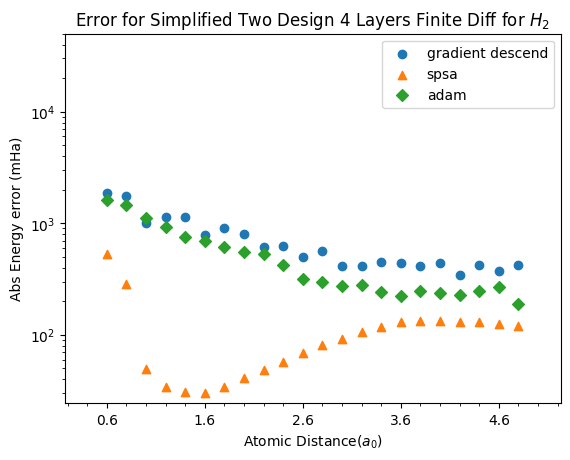

In [5]:
GRAD_METHOD_COMP = "fd" ## "fd" or "ps"
REF_ANSATZ = all_ansatz[0]

error_gradient = [np.abs(i-j)*1000 for i,j in zip(condensed_data[REF_ANSATZ][GRAD_METHOD_COMP]["energies"][optimizers[0]],fci_energies)]
error_spsa = [np.abs(i-j)*1000 for i,j in zip(condensed_data[REF_ANSATZ][GRAD_METHOD_COMP]["energies"][optimizers[1]],fci_energies)]
error_adam = [np.abs(i-j)*1000 for i,j in zip(condensed_data[REF_ANSATZ][GRAD_METHOD_COMP]["energies"][optimizers[2]],fci_energies)]

# Plot for errors
fig, ax = plt.subplots()

ax.scatter(test_points,error_gradient, label="gradient descend", marker='o')
ax.scatter(test_points,error_spsa, label="spsa", marker='^')
ax.scatter(test_points,error_adam, label="adam", marker='D')


ax.legend()
ax.set_title(f'Error for {DICT_ANSATZ[REF_ANSATZ]} {DICT_GRAD_METHOD[GRAD_METHOD_COMP]} for $H_{2}$')
ax.set_yscale('log',base=10) 
ax.set_ylabel('Abs Energy error (mHa)')
ax.set_xlabel('Atomic Distance($a_{0}$)')
ax.set_ylim(top=5e4)

ax.hlines(y=1.6, xmin=test_points[0] -0.2, xmax=test_points[-1]+0.2, linestyles='--', linewidth=2, color='black')
ax.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xticks(np.arange(min(test_points), max(test_points)+0.2, 1))

plt.show()



In [6]:
if False:
    for grad_method in DICT_GRAD_METHOD.keys():
        for ansatz_circ in DICT_ANSATZ.keys():

            error_gradient = [np.abs(i-j)*1000 for i,j in zip(condensed_data[ansatz_circ][grad_method]["energies"][optimizers[0]],fci_energies)]
            error_spsa = [np.abs(i-j)*1000 for i,j in zip(condensed_data[ansatz_circ][grad_method]["energies"][optimizers[1]],fci_energies)]
            error_adam = [np.abs(i-j)*1000 for i,j in zip(condensed_data[ansatz_circ][grad_method]["energies"][optimizers[2]],fci_energies)]        

            # Plot for errors
            fig, ax = plt.subplots()

            ax.scatter(test_points,error_gradient, label="gradient descend", marker='o')
            ax.scatter(test_points,error_spsa, label="spsa", marker='^')
            ax.scatter(test_points,error_adam, label="adam", marker='D')


            ax.legend()
            ax.set_title(f'Error for {DICT_ANSATZ[ansatz_circ]} {DICT_GRAD_METHOD[grad_method]} for $H_{2}$')
            ax.set_yscale('log',base=10) 
            ax.set_ylabel('Abs Energy error (mHa)')
            ax.set_xlabel('Atomic Distance($a_{0}$)')
            ax.set_ylim(top=5e3)

            ax.hlines(y=1.6, xmin=test_points[0] -0.2, xmax=test_points[-1]+0.2, linestyles='--', linewidth=2, color='black')
            ax.fill_between([test_points[0]-0.2,test_points[-1]+0.2],1.6, color="#1f77b450")

            ax.xaxis.set_minor_locator(MultipleLocator(0.2))
            ax.set_xticks(np.arange(min(test_points), max(test_points)+0.2, 1))

            plt.savefig(f'vqe_shots_{ansatz_circ}_{grad_method}.png')

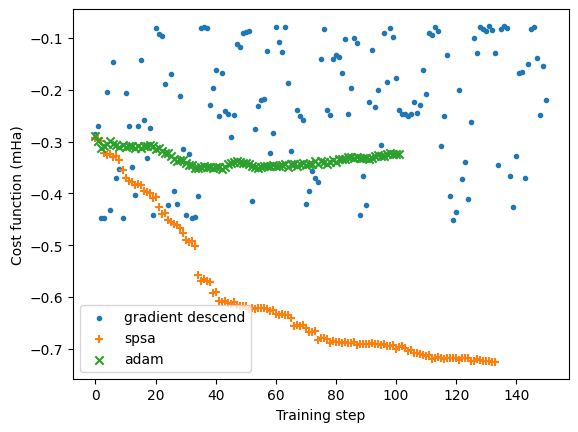

In [7]:
VARIANT= 0

GRAD_METHOD_COMP = "fd" ## "fd" or "ps"
REF_ANSATZ = all_ansatz[0]

meta_energies_gradient = DATA[REF_ANSATZ][GRAD_METHOD_COMP][VARIANT]["results"][optimizers[0]]["meta"]["energies"][0]
meta_energies_spsa = DATA[REF_ANSATZ][GRAD_METHOD_COMP][VARIANT]["results"][optimizers[1]]["meta"]["energies"][0]
meta_energies_adam = DATA[REF_ANSATZ][GRAD_METHOD_COMP][VARIANT]["results"][optimizers[2]]["meta"]["energies"][0]

# Plot for errors
fig, ax = plt.subplots()

ax.scatter([i for i in range(len(meta_energies_gradient))],meta_energies_gradient, label="gradient descend", marker='.')
ax.scatter([i for i in range(len(meta_energies_spsa))],meta_energies_spsa, label="spsa", marker='+')
ax.scatter([i for i in range(len(meta_energies_adam))],meta_energies_adam, label="adam", marker='x')
ax.legend()

# ax.set_title(f'Meta-VQE cost per training step {DICT_ANSATZ[REF_ANSATZ]} {DICT_GRAD_METHOD[GRAD_METHOD_COMP]}')
ax.set_ylabel('Cost function (mHa)')
ax.set_xlabel('Training step')

plt.show()

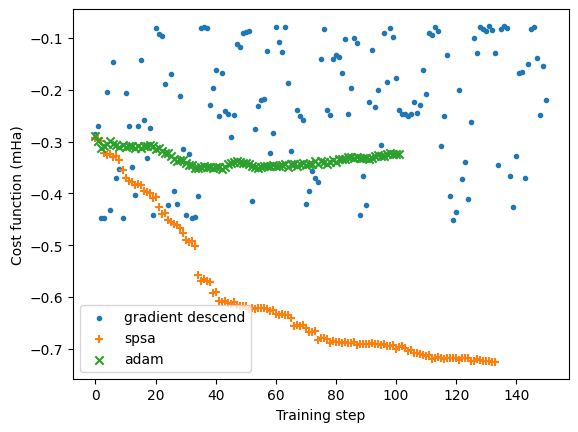

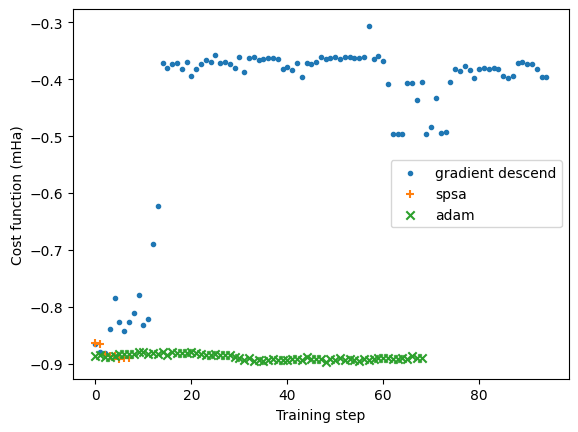

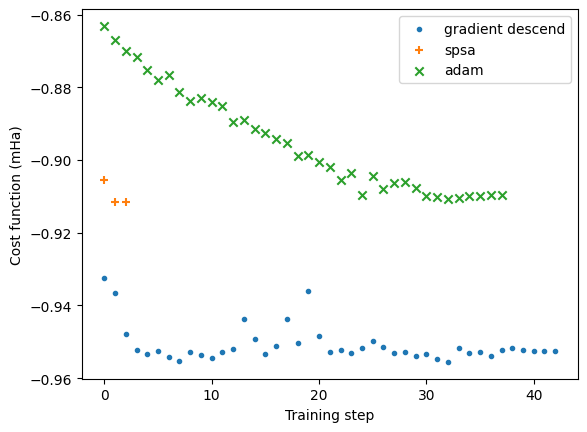

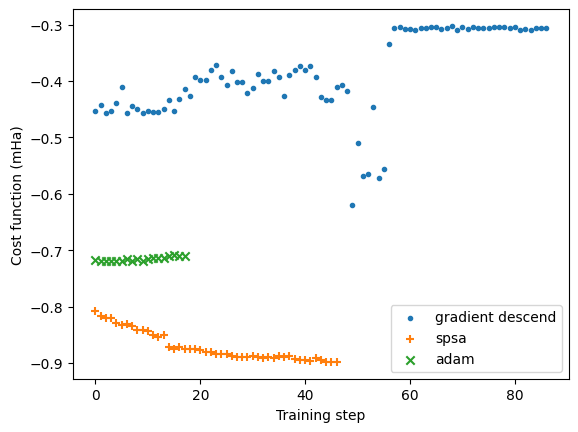

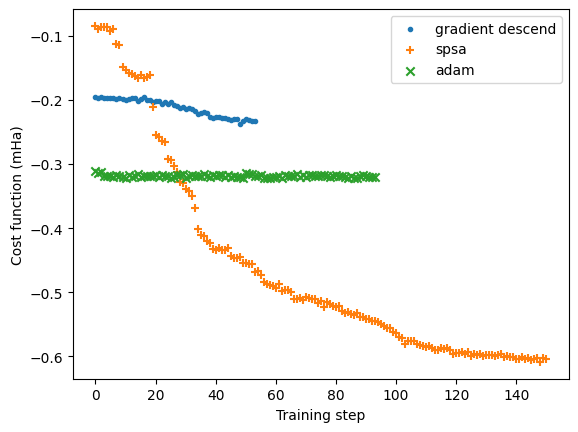

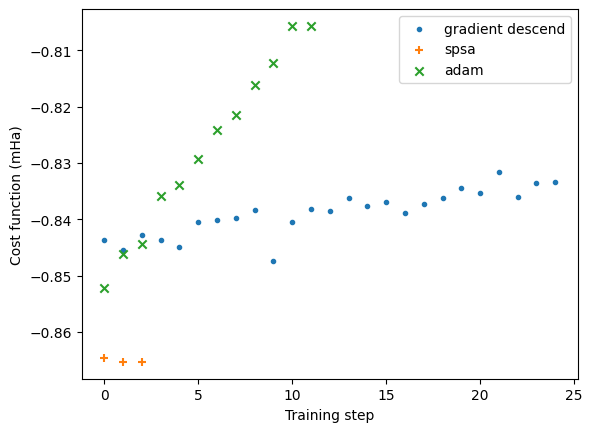

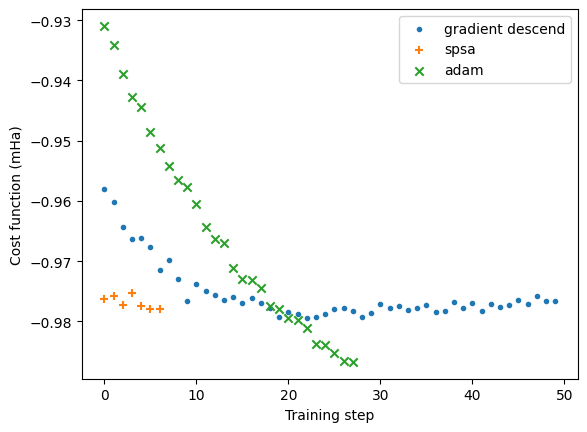

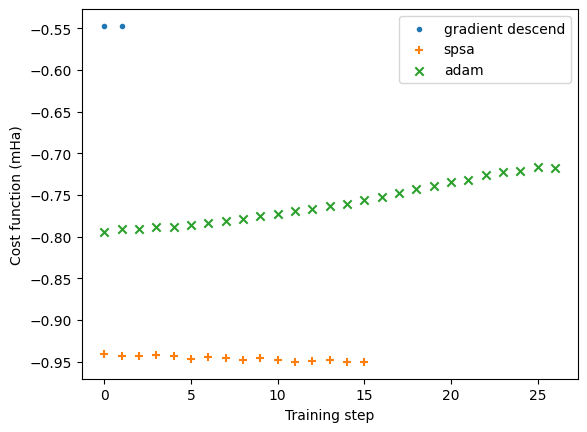

In [8]:
iteration = 3

if True:
    for grad_method in DICT_GRAD_METHOD.keys():
        for ansatz_circ in DICT_ANSATZ.keys():
            meta_energies_gradient = DATA[ansatz_circ][grad_method][VARIANT]["results"][optimizers[0]]["meta"]["energies"][0]
            meta_energies_spsa = DATA[ansatz_circ][grad_method][VARIANT]["results"][optimizers[1]]["meta"]["energies"][0]
            meta_energies_adam = DATA[ansatz_circ][grad_method][VARIANT]["results"][optimizers[2]]["meta"]["energies"][0]

            # Plot for errors
            fig, ax = plt.subplots()

            ax.scatter([i for i in range(len(meta_energies_gradient))],meta_energies_gradient, label="gradient descend", marker='.')
            ax.scatter([i for i in range(len(meta_energies_spsa))],meta_energies_spsa, label="spsa", marker='+')
            ax.scatter([i for i in range(len(meta_energies_adam))],meta_energies_adam, label="adam", marker='x')
            ax.legend()

            # ax.set_title(f'Meta-VQE cost per training step {DICT_ANSATZ[REF_ANSATZ]} {DICT_GRAD_METHOD[GRAD_METHOD_COMP]}')
            ax.set_ylabel('Cost function (mHa)')
            ax.set_xlabel('Training step')     

            plt.savefig(f'meta_vqe_shots_cost_{ansatz_circ}_{grad_method}.png')       